In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("derrom/")
sys.path.append("ELPH/")
sys.path.append("utils/")

import derrom
import ivp_integrator
import PHELPH


kmax = 2.5
n_kmax = 100

tmax = 10000
n_tmax = 1001
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

# #v1
# self.tau_photon = 1000
# self.g_photon = 0.01
# self.E_photon = 0.02
# self.linewidth = 0.005

#v2
system.g_photon = 0.02
system.tau_photon = 200
system.E_photon = 0.0175
system.linewidth = 0.005

system.setup_laser()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
I_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_I_kmax2.5_nkmax_100_n1000_v2.npz')
el_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_el_kmax2.5_nkmax_100_n1000_v2.npz')
el_scattering = derrom.utils.load_trajectories(filename='../PHELPH_el_scat_kmax2.5_nkmax_100_n1000_v2.npz')

n_sample = 1

I_trajectories = I_trajectories[::n_sample]
el_trajectories = el_trajectories[::n_sample]
el_scattering = el_scattering[::n_sample]

n_trajectories = len(el_trajectories)
n_kmax = el_trajectories[0].shape[1]

trajectories = [ np.concatenate([el_trajectories[k],I_trajectories[k].reshape(-1,1)], axis=1) for k in range(n_trajectories) ]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


cutoff = int(n_trajectories*0.9)

train_I_trajectories = I_trajectories[:cutoff]
train_el_trajectories = el_trajectories[:cutoff]
train_el_scattering = el_scattering[:cutoff]

test_I_trajectories = I_trajectories[cutoff:]
test_el_trajectories = el_trajectories[cutoff:]
test_el_scattering = el_scattering[cutoff:]

test_trajectories = trajectories[cutoff:]


1000 loaded with n_kmax = 100


In [30]:
dim_reducer = derrom.dim_reducers.SVD()

scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=500)
optimizer = derrom.optimizers.ridge(alpha=10.**2)

# scaler = derrom.scalers.normalize_scaler(0.1)
# transformer = derrom.transformers.polynomial_features(order=2)
# optimizer = derrom.optimizers.ridge(alpha=10.**-2.)

el_scat_model = derrom.derrom(train_el_trajectories, train_el_scattering, rdim=6, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

el_scat_model.train()

el_scat_model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  6
DE_l:  2
train shape:  (900900, 513)
target shape:  (900900, 100)
weights shape:  (513, 100)


In [5]:
def derivs(y):
    
    el_hist = y[:,:-1]
    el_state = y[-1,:-1]
    I = y[-1,-1]
    
    df = el_scat_model.predict(el_hist)
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)
    
    
    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9
    
    return np.concatenate((df[0],[dI]))

In [6]:
integrator = ivp_integrator.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

rms error: 0.6590882019806756
max error: 2.411361292724777
I_max error: -0.005451461594560398
I_max_pos error: 788
I_area error: 0.6925358064259424


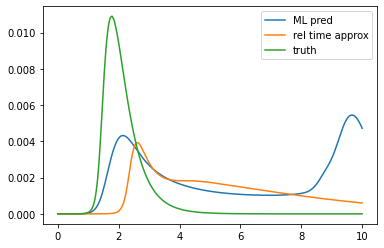

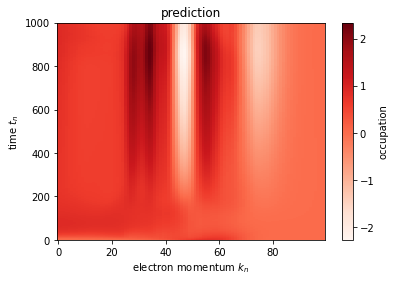

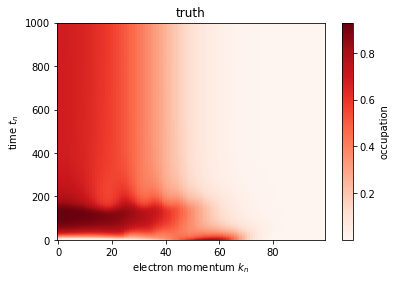

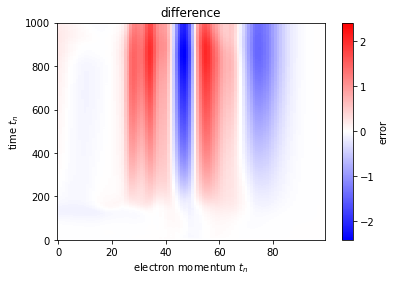

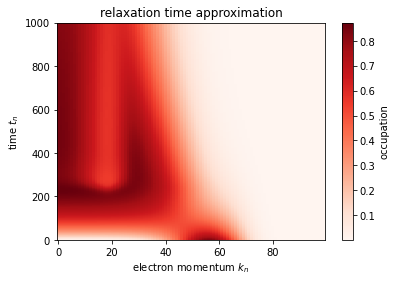

In [29]:
ind = 8

test_el_trajectory = test_el_trajectories[ind]
test_I_trajectory = test_I_trajectories[ind]
# test_trajectory = np.concatenate([test_el_trajectory,test_I_trajectory.reshape(-1,1)], axis=1)
test_trajectory = test_trajectories[ind]


# inits = np.concatenate((test_el_trajectory[0],[test_I_trajectory[0]])).reshape((1,-1))
inits = test_trajectory[:1]
# print(inits.shape)


pred = integrator.integrate(test_trajectory,test_el_trajectory.shape[0])


rel_time_approx = system.rel_time_approx(inits.flatten(),tmax=tmax, n_tmax=n_tmax,tau_rel=1000)


print('rms error:', integrator.get_error(test_trajectory,pred, norm='rms'))
print('max error:', integrator.get_error(test_trajectory,pred, norm='max'))
print('I_max error:', integrator.get_error(test_trajectory,pred, norm='I_max'))
print('I_max_pos error:', integrator.get_error(test_trajectory,pred, norm='I_max_pos'))
print('I_area error:', integrator.get_error(test_trajectory,pred, norm='I_area'))


plt.plot(t_vec/1000,pred[:,-1],label='ML pred')
plt.plot(t_vec/1000,rel_time_approx[:,-1],label='rel time approx')
plt.plot(t_vec/1000,test_I_trajectory,label='truth')
plt.legend()
plt.show()


derrom.utils.plot_trajectory(pred[:,:-1],title='prediction')

derrom.utils.plot_trajectory(test_el_trajectory,title='truth')

derrom.utils.plot_difference(truth=test_el_trajectory,test=pred[:,:-1])

derrom.utils.plot_trajectory(rel_time_approx[:,:-1],title='relaxation time approximation')


-7.852154085894523e-05


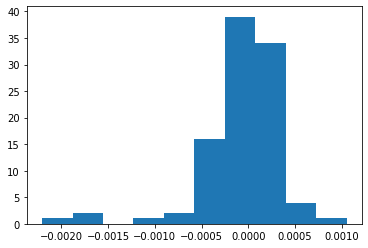

In [24]:
mean, mscores = integrator.score_multiple_trajectories(test_trajectories, norm='I_max')

print(mean)

plt.hist(mscores,bins=10)
plt.show()

In [5]:
dim_reducer = derrom.dim_reducers.SVD()

scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=500)
optimizer = derrom.optimizers.ridge(alpha=10.**2)

# scaler = derrom.scalers.normalize_scaler(0.1)
# transformer = derrom.transformers.polynomial_features(order=2)
# optimizer = derrom.optimizers.ridge(alpha=10.**-2.)

el_scat_model = derrom.derrom(rdim=6, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

integrator = ivp_integrator.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

scores = derrom.utils.get_KFold_CV_scores(integrator, trajectories, el_scattering, folds=10, seed=817,
                                          norms=['rms','max','I_max','I_max_pos','I_area'],
                                          train_kwargs={})

print('rms error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )
print('I_max error: ', str(np.mean(scores[2])) + ' +- ' + str(np.std(scores[2])) )
print('I_max_pos error: ', str(np.mean(scores[3])) + ' +- ' + str(np.std(scores[3])) )
print('I_area error: ', str(np.mean(scores[4])) + ' +- ' + str(np.std(scores[4])) )

rms error:  0.04136492281807343 +- 0.0674056171221229
max error:  0.2219626354059294 +- 0.4221641498349776
I_max error:  -0.00024404234814774523 +- 0.0009603816178198974
I_max_pos error:  3.49 +- 50.23060720317842
I_area error:  -0.012471301960652536 +- 0.10565647827679121


0.008485126029804786
0.9443071608635486
rms error:  0.04136492281807343 +- 0.0674056171221229
max error:  0.2219626354059294 +- 0.4221641498349776
I_max error:  -0.02876119309136058 +- 0.11318413120164257
I_max_pos error:  17.450000000000003 +- 251.1530360158921
I_area error:  -0.0132068276907355 +- 0.11188782914679016


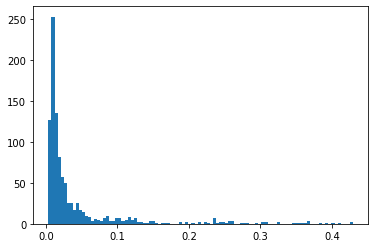

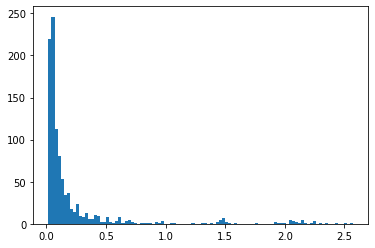

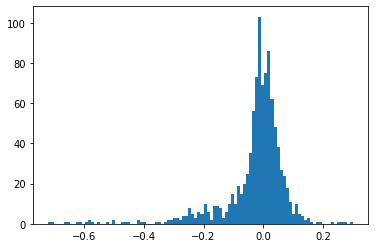

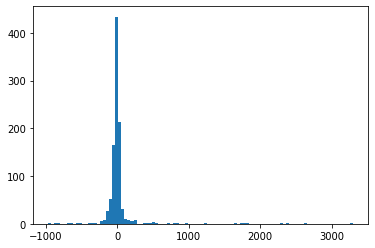

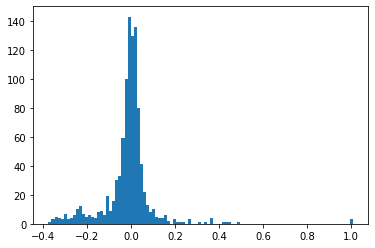

In [26]:
mean_I_max = np.mean([I.max() for I in I_trajectories])
print(mean_I_max)
mean_I_area = np.mean([np.sum(I) for I in I_trajectories])
print(mean_I_area)


print('rms error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )
print('I_max error: ', str(np.mean(scores[2])/mean_I_max) + ' +- ' + str(np.std(scores[2])/mean_I_max) )
print('I_max_pos error: ', str(np.mean(scores[3])*5.0) + ' +- ' + str(np.std(scores[3])*5.0) )
print('I_area error: ', str(np.mean(scores[4])/mean_I_area) + ' +- ' + str(np.std(scores[4])/mean_I_area) )

plt.hist(scores[0],bins=len(scores[0])//10)
plt.show()

plt.hist(scores[1],bins=len(scores[1])//10)
plt.show()

plt.hist(scores[2]/mean_I_max,bins=len(scores[2])//10)
plt.show()

plt.hist(np.array(scores[3])*5.0,bins=len(scores[3])//10)
plt.show()

plt.hist(scores[4]/mean_I_area,bins=len(scores[4])//10)
plt.show()

In [ ]:
masked_weights = np.ma.masked_values(el_scat_model.w,0.0)
plt.imshow(masked_weights, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(el_scat_model.w))))
plt.title('sorted weights')
plt.show()

plt.hist(np.ravel(el_scat_model.w), bins=200)
plt.title('weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

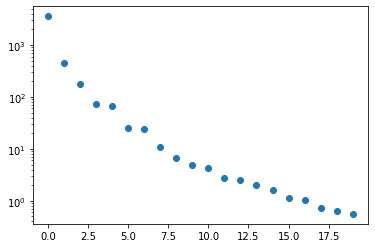

In [11]:
plt.semilogy(dim_reducer.S[:20], 'o')
plt.show()